# Expected Saves Model

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gkpose as gk
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from mplsoccer import VerticalPitch
from matplotlib.lines import Line2D

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
def val_accuracy(model, X_val, y_val):
    return np.mean(model.predict(X_val) == np.array(y_val))

In [3]:
def getxSInput(df, scaler, angle, dist, up=0, cluster=0, assist_type='Pass'):
    k = len(train_df.filter(regex='cluster').columns)
    angle_dist = scaler.transform([[angle,dist]])[0]
    up = np.array([up])
    clust = np.zeros(k)
    clust[cluster] = 1
    if assist_type == 'Cross':
        ass_t = np.array([1, 0, 0])
    elif assist_type == 'Other':
        ass_t = np.array([0, 1, 0])
    else:
        ass_t = np.array([0, 0, 1])
    return np.array([np.concatenate((angle_dist,up,clust))])

In [4]:
def importMLData(clusters_name, raw_name = 'raw_df'):
    df = pd.read_csv('ml/' + raw_name + '.csv')
    clusters = pd.read_csv('ml/' + clusters_name + '.csv')
    df['cluster'] = np.array(clusters['cluster'])
    return df

In [5]:
def getTrainTest(df):
    on_target = (df['shot_outcome_name'] == 'Goal') | (df['shot_outcome_name'] == 'Saved')
    features = ['photo_id','shot_outcome_name','cluster','shot_angle','distance_to_goal',
                'under_pressure']
    ml_df = df.loc[on_target, features].copy()
    ml_df['shot_outcome_name'].replace({'Goal': 0, 'Saved': 1}, inplace=True)
    ml_df = pd.get_dummies(ml_df, columns=['cluster'])
    ml_df = ml_df.reset_index(drop=True)
    test_ind = np.random.choice(range(ml_df.shape[0]), int(ml_df.shape[0] * 0.2))
    test_df = ml_df.loc[test_ind, :].copy()
    train_df = ml_df.drop(test_ind).reset_index(drop=True)
    return train_df, test_df

In [6]:
#df = importMLData(clusters_name = 'kmeans_2d_k4')

In [119]:
#train_df, test_df = getTrainTest(df)

## Pose Features: 2 Clusters

In [6]:
def getXSMap(train_df, model, scaler, num_clusters, up=0, ass='Pass'):
    #Sets: Probability Map
    x_range = np.linspace(90, 120.01, 50)
    y_range = np.linspace(0, 80, 50)
    xs_map = np.zeros((num_clusters, len(x_range), len(y_range)))
    for cluster in range(num_clusters):
        for x in range(len(x_range)):
            for y in range(len(y_range)):
                d = gk.distance_to_goal(shooter_x=x_range[x], shooter_y=y_range[y])
                a = gk.goal_angle(shooter_x=x_range[x], shooter_y=y_range[y])
                xs = []
                for n in range(num_clusters):
                    inp = getxSInput(train_df,scaler,angle=a,dist=d,up=up,cluster=n)
                    xs.append(model.predict_proba(inp)[0][1])
                mean_xs = np.mean(xs)
                inp = getxSInput(train_df,scaler,angle=a,dist=d,up=up,cluster=cluster)
                xs_map[cluster][x, y] = model.predict_proba(inp)[0][1] - mean_xs
        print("done cluster", cluster)
    return xs_map

In [7]:
def plotXSMap(xs_map, num_clusters, cluster_names, save='test'):
    pitch = VerticalPitch(half=True, goal_type='box', pad_bottom=-30, 
                          pad_left=-10, pad_right=-10, line_color='black')
    fig, ax = pitch.draw(figsize=(10, 5), nrows=1, ncols=num_clusters, tight_layout=True)
    for i in range(num_clusters):
        im = ax[i].imshow(xs_map[i], cmap=plt.cm.Greens, interpolation='none', 
                       vmin=-0.06, vmax=0.08, extent=[0,80,120,90])
        ax[i].set_title('Cluster ' + str(i) + ': ' + cluster_names[i])
    cax = plt.axes([1, 0.3, 0.05, 0.4])
    plt.colorbar(im, cax=cax)
    if save != 'test':
        plt.savefig('viz/1v1s/' + save + '.png', dpi=500, bbox_inches='tight')

In [8]:
def plotBestTechnique(xs_map):
    #Best technique to use
    pitch = VerticalPitch(half=True, goal_type='box', pad_bottom=-30, 
                          pad_left=-10, pad_right=-10, line_color='black',
                          orientation='horizontal')
    fig, ax = pitch.draw()
    cmap = plt.cm.tab20
    im = ax.imshow(np.argmax(xs_map, axis=0), cmap=cmap,
               interpolation='none', extent=[0,80,120,90])
    custom_lines = [Line2D([0], [0], color=cmap(0.), lw=4),
                    Line2D([0], [0], color=cmap(1.), lw=4)]
    ax.legend(custom_lines, ['Cluster 0: Set', 'Cluster 1: Engage'], 
              loc=1, bbox_to_anchor=(1, 1.08))
    #plt.savefig('viz/1v1s/optimal_technique_feat_2.png', dpi=500)

In [151]:
train_df = pd.read_csv('ml/train_feat_2.csv')
test_df = pd.read_csv('ml/test_feat_2.csv')

In [152]:
train_df.drop('shot_first_time', axis=1, inplace=True)

In [153]:
train_df.head()

,shot_outcome_name,shot_angle,distance_to_goal,under_pressure,cluster_0,cluster_1
0,1,4.763642,12.041595,0,1,0
1,0,45.000000,8.485281,0,1,0
2,0,35.753887,15.402922,0,1,0
3,1,53.972627,13.601471,0,1,0
4,1,23.629378,17.464249,0,1,0


In [154]:
train_df.describe()

,shot_outcome_name,shot_angle,distance_to_goal,under_pressure,cluster_0,cluster_1
count,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000
mean,0.464000,39.152617,11.360844,0.164000,0.668000,0.332000
std,0.499703,20.220392,4.157132,0.371018,0.471876,0.471876
min,0.000000,0.000000,2.828427,0.000000,0.000000,0.000000
25%,0.000000,22.258402,8.544004,0.000000,0.000000,0.000000
50%,0.000000,41.185925,11.180340,0.000000,1.000000,0.000000
75%,1.000000,54.339898,14.212670,0.000000,1.000000,1.000000
max,1.000000,84.289407,23.345235,1.000000,1.000000,1.000000


In [155]:
scaler = StandardScaler().fit(train_df[['shot_angle','distance_to_goal']])
train_df[['shot_angle','distance_to_goal']] = scaler.transform(train_df[['shot_angle','distance_to_goal']])

In [156]:
#Get training set X and y
y = train_df.pop('shot_outcome_name')
X = train_df.values
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

### SVM

In [157]:
svm = SVC(C=1.0, kernel='rbf',probability=True).fit(X_train, y_train)
val_accuracy(svm, X_val, y_val)

0.64

### Logistic Regression

In [158]:
lr = LogisticRegression(penalty='none', random_state=0).fit(X_train, y_train)
val_accuracy(lr, X_val, y_val)

0.56

In [159]:
rf = RandomForestClassifier(max_depth=2, random_state=0).fit(X_train, y_train)
val_accuracy(rf, X_val, y_val)

0.66

In [160]:
nb = GaussianNB().fit(X_train, y_train)
val_accuracy(nb, X_val, y_val)

0.62

In [164]:
xs_map = getXSMap(train_df, svm, scaler, num_clusters=2, up=0)

done cluster 0
done cluster 1


In [169]:
xs_map_up = getXSMap(train_df, svm, scaler, num_clusters=2, up=1)

done cluster 0
done cluster 1


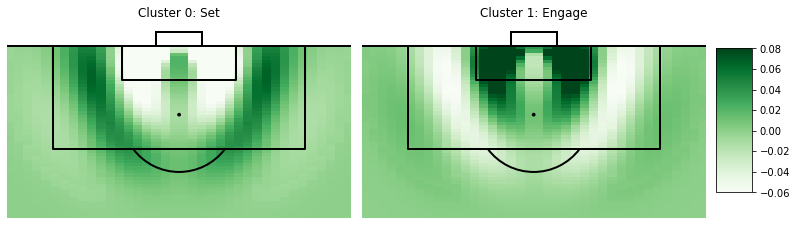

In [200]:
plotXSMap(xs_map, num_clusters=2, cluster_names=['Set', 'Engage'], save='feat_2_xsmap')

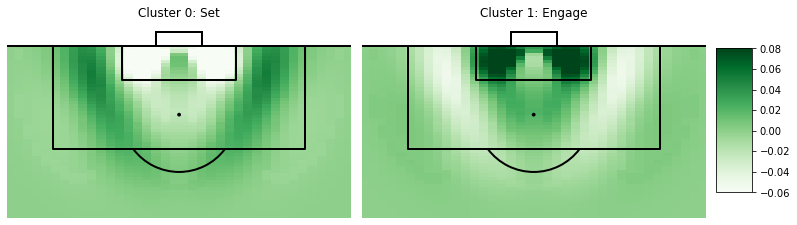

In [201]:
plotXSMap(xs_map_up, num_clusters=2, cluster_names=['Set', 'Engage'], save='feat_2_xsmap_up')

In [9]:
def plotBestTechniqueUp(xs_map, xs_map_up, save='test'):
    #Best technique to use
    pitch = VerticalPitch(half=True, goal_type='box', pad_bottom=-30, 
                          pad_left=-10, pad_right=-10, line_color='black',
                          orientation='horizontal')
    fig, ax = pitch.draw(figsize=(10,5), nrows=1, ncols=2)
    cmap = plt.cm.tab20
    im = ax[0].imshow(np.argmax(xs_map, axis=0), cmap=cmap,
                      interpolation='none', extent=[0,80,120,90])
    im = ax[1].imshow(np.argmax(xs_map_up, axis=0), cmap=cmap,
                      interpolation='none', extent=[0,80,120,90])
    ax[0].set_title('Striker Not Under Pressure')
    ax[1].set_title('Striker Under Pressure')
    custom_lines = [Line2D([0], [0], color=cmap(0.), lw=4),
                    Line2D([0], [0], color=cmap(1.), lw=4)]
    ax[1].legend(custom_lines, ['Cluster 0: Set', 'Cluster 1: Engage'], 
              loc=1, bbox_to_anchor=(1, 0.22))
    if save != 'test':
        plt.savefig('viz/1v1s/' + save + '.png', dpi=500, bbox_inches='tight')

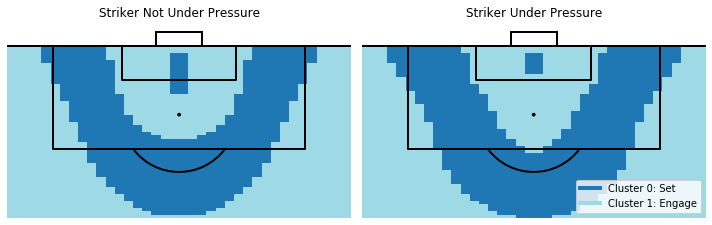

In [198]:
plotBestTechniqueUp(xs_map, xs_map_up, save='optimal_technique_feat_2')

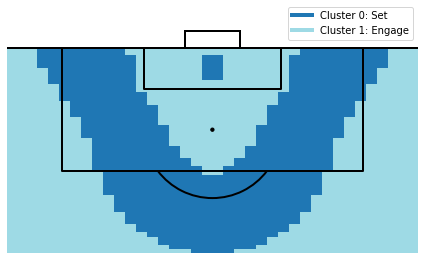

In [173]:
plotBestTechnique(xs_map_up)

## Alternative Method: Features, k=2

In [57]:
df = importMLData(clusters_name = 'kmeans_feat_k2')

In [58]:
df.head()

,file,photo_id,duration,play_pattern_name,under_pressure,shot_outcome_name,shot_first_time,distance_to_goal,shot_angle,gk_name,gk_engage,assist_type,cluster
0,382-2.png,382,0.186800,From Free Kick,0,Saved,0,7.280110,74.054604,Jonas Lössl,0.566352,Other,1
1,537-2.png,537,0.771300,From Throw In,0,Goal,0,11.313708,45.000000,Mathew Ryan,1.000000,Pass,0
2,476-2.png,476,0.714875,Regular Play,0,Saved,0,12.041595,4.763642,Tom Heaton,0.332182,Pass,0
3,63.png,63,0.533000,From Free Kick,0,Goal,1,8.485281,45.000000,Eiji Kawashima,0.687184,Pass,0
4,88.png,88,0.960000,Regular Play,1,Off T,0,20.248457,57.094757,Hugo Lloris,0.931822,Pass,0


In [86]:
train_df, test_df = getTrainTest(df)

In [87]:
train_df.drop('photo_id', axis=1, inplace=True)

In [89]:
scaler = StandardScaler().fit(train_df[['shot_angle','distance_to_goal']])
train_df[['shot_angle','distance_to_goal']] = scaler.transform(train_df[['shot_angle','distance_to_goal']])

In [90]:
#Get training set X and y
y = train_df.pop('shot_outcome_name')
X = train_df.values
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [91]:
svm = SVC(C=1.0, kernel='rbf',probability=True).fit(X_train, y_train)
val_accuracy(svm, X_val, y_val)

0.6470588235294118

In [92]:
xs_map = getXSMap(train_df, svm, scaler, num_clusters=2, up=0)

done cluster 0
done cluster 1


In [93]:
xs_map_up = getXSMap(train_df, svm, scaler, num_clusters=2, up=1)

done cluster 0
done cluster 1


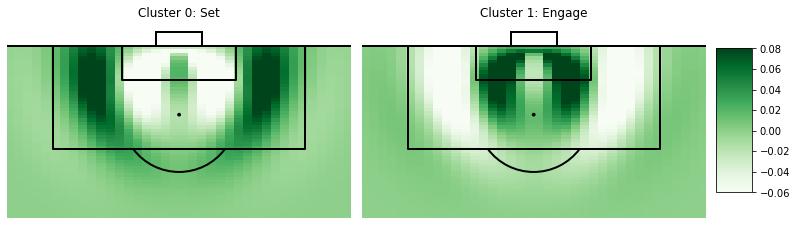

In [94]:
plotXSMap(xs_map, num_clusters=2, cluster_names=['Set', 'Engage'], save='test')

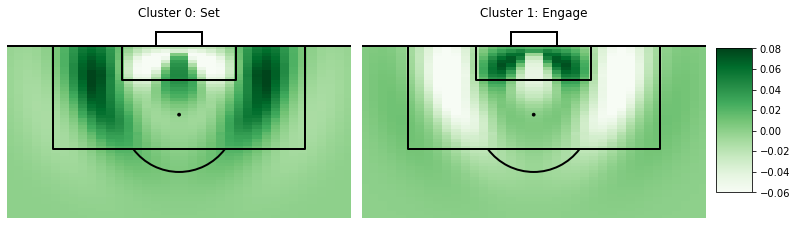

In [95]:
plotXSMap(xs_map_up, num_clusters=2, cluster_names=['Set', 'Engage'], save='test')

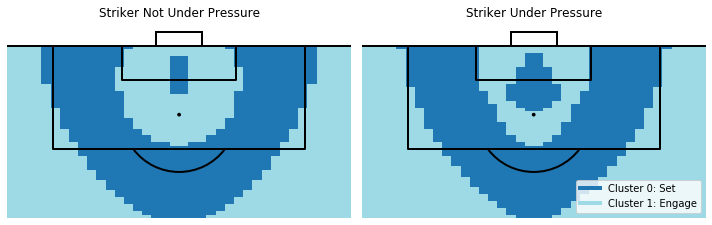

In [96]:
plotBestTechniqueUp(xs_map, xs_map_up, save='test')

### Find instances where keeper made bad decision

In [99]:
test_df = test_df.reset_index(drop=True)

In [127]:
test_df.filter(regex='cluster_')

,cluster_0,cluster_1
0,0,1
1,0,1
2,1,0
3,1,0
4,1,0
...,...,...
56,1,0
57,1,0
58,0,1
59,1,0


In [131]:
test_df['chosen_cluster'] = np.argmax(test_df.filter(regex='cluster_').values, axis=1)

In [116]:
optimal_cluster = []
num_clusters = 2
for i in range(len(test_df)):
    angle = test_df.loc[i, 'shot_angle']
    dist = test_df.loc[i, 'distance_to_goal']
    up = test_df.loc[i, 'under_pressure']
    xs_list = []
    for cluster in range(num_clusters):
        inp = getxSInput(df, scaler, angle=angle, dist=dist, up=up, cluster=cluster)
        xs_list.append(svm.predict_proba(inp)[0][1])
    optimal_cluster.append(np.argmax(xs_list))

In [123]:
test_df['optimal_cluster'] = optimal_cluster

In [137]:
#Number of correctly chosen save technique by the goalkeeper
print(np.sum(test_df['optimal_cluster'] == test_df['chosen_cluster']))
print(len(test_df))

34
61


In [140]:
#Wrong Save Choices
wrong_choices = test_df.loc[test_df['optimal_cluster'] != test_df['chosen_cluster']][['photo_id','optimal_cluster','chosen_cluster']]

In [141]:
wrong_choices

,photo_id,optimal_cluster,chosen_cluster
0,409,0,1
2,476,1,0
3,390,1,0
4,497,1,0
7,463,1,0
9,63,1,0
11,9,1,0
12,136,1,0
13,240,1,0
16,182,1,0


In [142]:
wrong_choices.to_csv('wrong_save_choice_k2.csv', index=False)

## 2d Poses: 4 Clusters

In [36]:
df = importMLData(clusters_name = 'kmeans_2d_k4')

In [37]:
train_df, test_df = getTrainTest(df)

In [38]:
train_df.drop('photo_id', axis=1, inplace=True)

In [39]:
scaler = StandardScaler().fit(train_df[['shot_angle','distance_to_goal']])
train_df[['shot_angle','distance_to_goal']] = scaler.transform(train_df[['shot_angle','distance_to_goal']])

In [40]:
#Get training set X and y
y = train_df.pop('shot_outcome_name')
X = train_df.values
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [41]:
svm = SVC(C=1.0, kernel='rbf',probability=True).fit(X_train, y_train)
val_accuracy(svm, X_val, y_val)

0.72

In [42]:
xs_map = getXSMap(train_df, svm, scaler, num_clusters=4, up=0)

done cluster 0
done cluster 1
done cluster 2
done cluster 3


In [43]:
xs_map_up = getXSMap(train_df, svm, scaler, num_clusters=4, up=1)

done cluster 0
done cluster 1
done cluster 2
done cluster 3


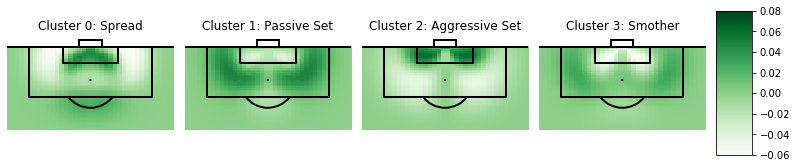

In [48]:
plotXSMap(xs_map, num_clusters=4, cluster_names=['Spread','Passive Set','Aggressive Set','Smother'], save='2d_4_xsmap')

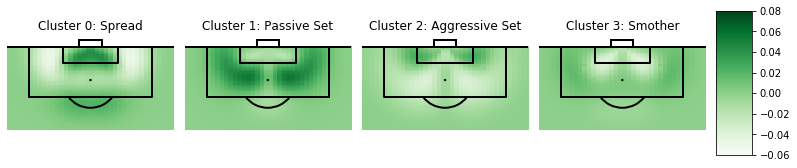

In [49]:
plotXSMap(xs_map_up, num_clusters=4, cluster_names=['Spread','Passive Set','Aggressive Set','Smother'], save='2d_4_xsmap_up')

In [46]:
def plotBestTechniqueUp(xs_map, xs_map_up, save='test'):
    #Best technique to use
    pitch = VerticalPitch(half=True, goal_type='box', pad_bottom=-30, 
                          pad_left=-10, pad_right=-10, line_color='black',
                          orientation='horizontal')
    fig, ax = pitch.draw(figsize=(10,5), nrows=1, ncols=2)
    cmap = plt.cm.tab20
    im = ax[0].imshow(np.argmax(xs_map, axis=0), cmap=cmap,
                      interpolation='none', extent=[0,80,120,90])
    im = ax[1].imshow(np.argmax(xs_map_up, axis=0), cmap=cmap,
                      interpolation='none', extent=[0,80,120,90])
    ax[0].set_title('Striker Not Under Pressure')
    ax[1].set_title('Striker Under Pressure')
    custom_lines = [Line2D([0], [0], color=cmap(0.), lw=4),
                    Line2D([0], [0], color=cmap(0.33), lw=4),
                    Line2D([0], [0], color=cmap(0.66), lw=4),
                    Line2D([0], [0], color=cmap(1.), lw=4)]
    ax[1].legend(custom_lines, ['Cluster 0: Spread', 'Cluster 1: Passive Set','Cluster 2: Aggressive Set','Cluster 3: Smother'], 
              loc=1, bbox_to_anchor=(1, 0.38))
    if save != 'test':
        plt.savefig('viz/1v1s/' + save + '.png', dpi=500, bbox_inches='tight')

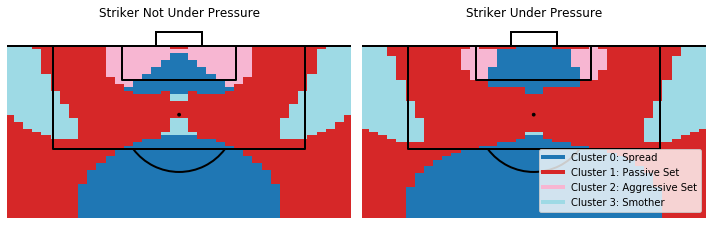

In [50]:
plotBestTechniqueUp(xs_map, xs_map_up, save='optimal_technique_2d_4')